# Deploy the model in Azure Container Instances
This tutorial is part two of a two-part tutorial series. In the previous tutorial, you trained machine learning models and then registered a model in your workspace on the cloud.

Now you're ready to deploy the model as a web service in Azure Container Instances. A web service is an image, in this case a Docker image. It encapsulates the scoring logic and the model itself.

### Import the packages

In [12]:
%matplotlib inline
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
 
import azureml
from azureml.core import Workspace, Run

# display the core SDK version number
print("Azure ML SDK Version: ", azureml.core.VERSION)

Azure ML SDK Version:  1.0.57


### Retrieve the model
You registered a model in your workspace in the previous tutorial. Now load this workspace and download the model to your local directory.

In [13]:
from azureml.core import Workspace
from azureml.core.model import Model
import os
ws = Workspace.from_config()
model = Model(ws, 'sklearn_mnist')

model.download(target_dir=os.getcwd(), exist_ok=True)

# verify the downloaded model file
file_path = os.path.join(os.getcwd(), "sklearn_mnist_model.pkl")

os.stat(file_path)

os.stat_result(st_mode=33206, st_ino=4785074604624088, st_dev=270394477, st_nlink=1, st_uid=0, st_gid=0, st_size=63684, st_atime=1567084600, st_mtime=1567088125, st_ctime=1567007869)

### Test the model locally
To do so, we are going to import the data, call the saved model to predict on the test data and evaluate the model by examining the confusion matrix.

In [14]:
# Import the data
from utils import load_data
import os

data_folder = os.path.join(os.getcwd(), 'data')
# note we also shrink the intensity values (X) from 0-255 to 0-1. This helps the neural network converge faster
X_test = load_data(os.path.join(data_folder, 'test-images.gz'), False) / 255.0
y_test = load_data(os.path.join(data_folder, 'test-labels.gz'), True).reshape(-1)

# Predict on test set
import pickle
from sklearn.externals import joblib

clf = joblib.load(os.path.join(os.getcwd(), 'sklearn_mnist_model.pkl'))
y_hat = clf.predict(X_test)

# Evaluate
from sklearn.metrics import confusion_matrix

conf_mx = confusion_matrix(y_test, y_hat)
print(conf_mx)
print('Overall accuracy:', np.average(y_hat == y_test))

[[ 960    0    2    2    1    4    6    3    1    1]
 [   0 1113    3    1    0    1    5    1   11    0]
 [   9    8  919   20    9    5   10   12   37    3]
 [   4    0   17  918    2   24    4   11   21    9]
 [   1    3    4    3  913    0   10    3    6   39]
 [  10    2    0   42   11  768   17    7   28    7]
 [   9    3    7    2    6   20  907    1    3    0]
 [   2    9   22    5    8    1    1  948    5   27]
 [  10   15    5   21   15   26    7   11  852   12]
 [   7    8    2   14   32   13    0   26   12  895]]
Overall accuracy: 0.9193


If a confusion matrix appears, the model has been correctly built!

## Deploy as a web service
To deploy the model, we must provide the following components:
- A __scoring script__ to show how to use the model.
- An __environment file__ to show what packages need to be installed.
- A __configuration file__ to build the container instance.
- The __trained model__.

### Create a scoring script
The scoring script must contain the folloing functions:
- The _init()_ function, which loads the model into a global object. It runs only once when the Docker container is started.
- The _run(input_data)_ function uses the model to predict a value based on the input data.

In [15]:
%%writefile score.py
import json
import numpy as np
import os
import pickle
from sklearn.externals import joblib
from sklearn.linear_model import LogisticRegression

from azureml.core.model import Model

def init():
    global model
    # retrieve the path to the model file using the model name
    model_path = Model.get_model_path('sklearn_mnist')
    model = joblib.load(model_path)

def run(raw_data):
    data = np.array(json.loads(raw_data)['data'])
    # make prediction
    y_hat = model.predict(data)
    # you can return any data type as long as it is JSON-serializable
    return y_hat.tolist()

Overwriting score.py


### Create the environment file
This file is used to make sure that all of those dependencies are installed in the Docker image.

In [16]:
from azureml.core.conda_dependencies import CondaDependencies 

myenv = CondaDependencies()
myenv.add_conda_package("scikit-learn")

with open("myenv.yml", "w") as f:
    f.write(myenv.serialize_to_string())

### Create a configutation file 
Specify the number of CPUs and gigabytes of RAM needed for your Container Instances container.

In [17]:
from azureml.core.webservice import AciWebservice

aciconfig = AciWebservice.deploy_configuration(cpu_cores=1, 
                                               memory_gb=1, 
                                               tags={"data": "MNIST",  
                                                     "method": "sklearn"},
                                               description='Predict MNIST with sklearn')

### Deploy in Container Instances

Now we have all we need to deploy our model in a container instance.

We must then:
- Build and image by using the scoring file, environment file and model file.
- Register the image under the workspace.
- Send the image to the Container Instances container.
- Start up a container in Container Instances by using the image.
- Get the web service HTTP endpoint.

In [18]:
%%time
from azureml.core.webservice import Webservice
from azureml.core.model import InferenceConfig

inference_config = InferenceConfig(runtime= "python", 
                                   entry_script="score.py",
                                   conda_file="myenv.yml")

service = Model.deploy(workspace=ws, 
                       name='sklearn-mnist-svc',
                       models=[model], 
                       inference_config=inference_config,
                       deployment_config=aciconfig)

service.wait_for_deployment(show_output=True)

Creating service
Running...........................
SucceededACI service creation operation finished, operation "Succeeded"
Wall time: 2min 27s


Get the scoring web service's HTTP endpoint, which accepts REST client calls. You can share this endpoint with anyone who wants to test the web service or integrate it into an application:

In [19]:
print(service.scoring_uri)

http://1fa2074d-18eb-41fd-812f-c38f8367b160.eastus2.azurecontainer.io/score


## Test the deployed service
Predict 30 images from the test set with the deployed model.

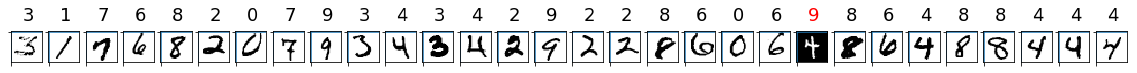

In [20]:
import json

# find 30 random samples from test set
n = 30
sample_indices = np.random.permutation(X_test.shape[0])[0:n]

test_samples = json.dumps({"data": X_test[sample_indices].tolist()})
test_samples = bytes(test_samples, encoding='utf8')

# predict using the deployed model
result = service.run(input_data=test_samples)

# compare actual value vs. the predicted values:
i = 0
plt.figure(figsize=(20, 1))

for s in sample_indices:
    plt.subplot(1, n, i + 1)
    plt.axhline('')
    plt.axvline('')
    
    # use different color for misclassified sample
    font_color = 'red' if y_test[s] != result[i] else 'black'
    clr_map = plt.cm.gray if y_test[s] != result[i] else plt.cm.Greys
    
    plt.text(x=10, y=-10, s=result[i], fontsize=18, color=font_color)
    plt.imshow(X_test[s].reshape(28, 28), cmap=clr_map)
    
    i = i + 1
plt.show()

You can also send a raw HTTP request to test the web service:

In [21]:
import requests

# send a random row from the test set to score
random_index = np.random.randint(0, len(X_test)-1)
input_data = "{\"data\": [" + str(list(X_test[random_index])) + "]}"

headers = {'Content-Type': 'application/json'}

# for AKS deployment you'd need to the service key in the header as well
# api_key = service.get_key()
# headers = {'Content-Type':'application/json',  'Authorization':('Bearer '+ api_key)} 

resp = requests.post(service.scoring_uri, input_data, headers=headers)

print("POST to url", service.scoring_uri)
#print("input data:", input_data)
print("label:", y_test[random_index])
print("prediction:", resp.text)

POST to url http://1fa2074d-18eb-41fd-812f-c38f8367b160.eastus2.azurecontainer.io/score
label: 8
prediction: [8]


### Clean up ressources
Clean the Container Instances deployment by using the following cell's call. Delete the resource group as well from the Azure Portal.

In [22]:
service.delete()